In [8]:
!pip install contractions


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 6.8 MB/s eta 0:00:00


In [25]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import pandas as pd 
df = pd.read_csv('/kaggle/input/-coffeemakerclassification/coffee_maker.csv', usecols=['review', 'rating'])
df.rename(columns={'rating': 'sentiment'}, inplace=True)
df = df[['review', 'sentiment']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   review     4999 non-null   object 
 1   sentiment  5000 non-null   float64
dtypes: float64(1), object(1)
memory usage: 78.2+ KB


In [2]:
df.head()


,review,sentiment
0,Delightful coffee maker if you’re only looking...,2.0
1,UPDATE: Bought this 10-21-18 and I finally ret...,1.0
2,The big reason I ordered this was because I wa...,4.0
3,I've owned several of their older brewstation ...,5.0
4,I agonized over which coffee maker to purchase...,3.0


## EDA


In [4]:
df = df[(df.sentiment != 3.0 )]
df = df.replace({"sentiment": {1.0: 'negative', 2.0: 'negative', 4.0: 'positive', 5.0: 'positive'}})
df.dropna(inplace=True)
df.head()

,review,sentiment
0,Delightful coffee maker if you’re only looking...,negative
1,UPDATE: Bought this 10-21-18 and I finally ret...,negative
2,The big reason I ordered this was because I wa...,positive
3,I've owned several of their older brewstation ...,positive
5,I loved the convenience of having a coffee bre...,negative


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4545 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     4545 non-null   object
 1   sentiment  4545 non-null   object
dtypes: object(2)
memory usage: 106.5+ KB


## Data Visualization

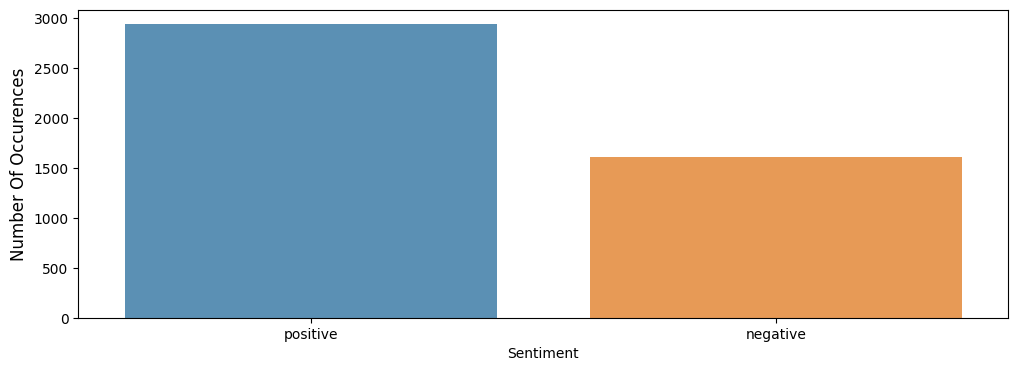

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sentiment = df["sentiment"].value_counts()
plt.figure(figsize=(12, 4))
sns.barplot(x=sentiment.index, y=sentiment.values, alpha=0.8)
plt.ylabel('Number Of Occurences', fontsize=12)
plt.xlabel("Sentiment")
plt.show()

## Data Cleaning

In [7]:
from bs4 import BeautifulSoup

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def stopwords_removal(words):
    list_stopwords = nltk.corpus.stopwords.words('english')
    return [word for word in words if word not in list_stopwords ]

In [13]:
import re
import nltk
import tqdm
import unicodedata
import contractions

from nltk.tokenize import word_tokenize

def preprocess_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        doc = doc.lower()
        doc = strip_html_tags(doc)
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        doc = remove_accented_chars(doc)
        doc = contractions.fix(doc)
        doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
        doc = re.sub(" +", " ", doc)
        doc = doc.strip()
        
        doc = word_tokenize(doc)
        
        doc = stopwords_removal(doc)
        norm_docs.append(doc)
        
    norm_docs = [" ".join(word) for word in norm_docs]
    return norm_docs

In [14]:
%%time
df.review = preprocess_corpus(df.review)

 16%|█▋        | 745/4545 [00:00<00:03, 1223.31it/s]/tmp/ipykernel_32/1563358184.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|██████████| 4545/4545 [00:02<00:00, 1857.26it/s]

CPU times: user 2.32 s, sys: 123 ms, total: 2.44 s
Wall time: 2.46 s


In [15]:
df.head()

,review,sentiment
0,delightful coffee maker looking use one year d...,negative
1,update bought 102118 finally retired pos trash...,negative
2,big reason ordered tired dealing coffee carafe...,positive
3,owned several older brewstation models last 7y...,positive
5,loved convenience coffee brewer kept coffee ho...,negative


## Data Transformation TF-IDF

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer()
text_df = tf.fit_transform(df['review'].astype('U'))

## Data Splitting

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(text_df, df['sentiment'], test_size=0.1, random_state=42)

## Model

### Naive Bayes

In [26]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix

clf_nb = MultinomialNB().fit(X_train, y_train)
y_pred_nb = clf_nb.predict(X_test)

print("MultinomialNB Accuracy: %.2f%% " %(accuracy_score(y_test, y_pred_nb)* 100))
print("MultinomialNB Precision: %.2f%% " %(precision_score(y_test, y_pred_nb, average="macro", pos_label="negative")* 100))
print("MultinomialNB Recall: %.2f%% " %(recall_score(y_test, y_pred_nb, average="macro", pos_label="negative")* 100))
print("MultinomialNB F1 Score: %.2f%% " %(f1_score(y_test, y_pred_nb, average="macro", pos_label="negative")* 100))

print(f"confusion matrix: \n {confusion_matrix(y_test, y_pred_nb)}")
print(classification_report(y_test, y_pred_nb, zero_division=0))

MultinomialNB Accuracy: 85.93% 
MultinomialNB Precision: 88.30% 
MultinomialNB Recall: 78.53% 
MultinomialNB F1 Score: 81.38% 
confusion matrix: 
 [[ 83  57]
 [  7 308]]
              precision    recall  f1-score   support

    negative       0.92      0.59      0.72       140
    positive       0.84      0.98      0.91       315

    accuracy                           0.86       455
   macro avg       0.88      0.79      0.81       455
weighted avg       0.87      0.86      0.85       455



### SVM

In [27]:
from sklearn import svm

clf_svm = svm.SVC(kernel='linear').fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)
print("Support Vector Machine Accuracy: %.2f%% " % (accuracy_score(y_test,y_pred_svm)*100))
print("Support Vector Machine Precision: %.2f%% " % (precision_score(y_test,y_pred_svm, average="macro", pos_label="negative")*100))
print("Support Vector Machine Recall: %.2f%% " % (recall_score(y_test,y_pred_svm, average="macro", pos_label="negative")*100))
print("Support Vector Machine f1_score: %.2f%% " % (f1_score(y_test,y_pred_svm, average="macro", pos_label="negative")*100))

print(f'confusion matrix:\n {confusion_matrix(y_test, y_pred_svm)}')
print('================================================\n') 
print(classification_report(y_test, y_pred_svm, zero_division=0)) 

Support Vector Machine Accuracy: 88.57% 
Support Vector Machine Precision: 86.79% 
Support Vector Machine Recall: 86.19% 
Support Vector Machine f1_score: 86.48% 
confusion matrix:
 [[112  28]
 [ 24 291]]

              precision    recall  f1-score   support

    negative       0.82      0.80      0.81       140
    positive       0.91      0.92      0.92       315

    accuracy                           0.89       455
   macro avg       0.87      0.86      0.86       455
weighted avg       0.88      0.89      0.89       455



### Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier().fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
print("Random Forest Accuracy: %.2f%% " % (accuracy_score(y_test,y_pred_rf)*100))
print("Random Forest Precision: %.2f%% " % (precision_score(y_test,y_pred_rf, average="macro", pos_label="negative" )*100))
print("Random Forest Recall: %.2f%% " % (recall_score(y_test,y_pred_rf, average="macro", pos_label="negative")*100))
print("Random Forest f1_score: %.2f%% " % (f1_score(y_test,y_pred_rf, average="macro", pos_label="negative")*100))

print(f'confusion matrix:\n {confusion_matrix(y_test, y_pred_rf)}')
print('================================================\n') 
print(classification_report(y_test, y_pred_rf, zero_division=0))

Random Forest Accuracy: 88.57% 
Random Forest Precision: 87.78% 
Random Forest Recall: 84.80% 
Random Forest f1_score: 86.06% 
confusion matrix:
 [[105  35]
 [ 17 298]]

              precision    recall  f1-score   support

    negative       0.86      0.75      0.80       140
    positive       0.89      0.95      0.92       315

    accuracy                           0.89       455
   macro avg       0.88      0.85      0.86       455
weighted avg       0.88      0.89      0.88       455

